In [1]:
crash.data <- read.table("Intersections.csv", sep=",", header=T)
crash.data

INTERSECTION_ID,COUNTY,INTERSECTION_GEO,RELATION_TO_CURVE,DIST_TO_CURVE,DIST_TO_INT,INTERSECTION_TYPE,INTERSECTION_SHAPE,INTERSECTION_LEG,INTERSECTION_ANGLE,⋯,MIN_AADT_2015RCI,MAX_FUNCLASS,MIN_FUNCLASS,MAX_SPEEDCAT,MIN_SPEEDCAT,MAX_LANECAT,MIN_LANECAT,IF_INTERSECT_ONSYSRD,CRASH_HE_SE,CRASH_HE_SE_TYPE_ANGLE
3364,GADSDEN,1,on curve,0.00000,368.39700,3wayY,Y,3,79.3,,1100,4,4,4,4,1,1,N,0,0
3395,GULF,1,have dist,271.87821,96.59101,4wayCross,Cross,4,90.0,,0,5,4,6,5,1,1,N,0,0
3415,LEVY,1,have dist,307.26485,172.10507,4wayX,X,4,52.4,,200,5,4,5,3,1,1,N,1,1
3420,LEVY,1,have dist,1541.78804,600.82020,4wayCross,Cross,4,90.0,,550,4,4,5,4,1,1,N,1,0
8743,GULF,1,have dist,192.84716,84.95888,4wayCross,Cross,4,90.0,,0,5,5,5,5,1,1,N,0,0
9287,BRADFORD,1,have dist,241.43084,409.22474,3wayY,Y,3,66.3,,0,5,5,5,5,1,1,N,0,0
9326,UNION,1,have dist,251.23687,395.84340,3wayY,Y,3,70.3,,450,5,4,5,4,1,1,N,0,0
9375,UNION,1,have dist,376.33429,346.52205,3wayT,T,3,90.0,,600,5,4,6,6,1,1,N,0,0
9377,BRADFORD,1,have dist,155.84691,178.96182,3wayY,Y,3,82.3,,2500,5,4,5,3,1,1,N,0,0
9389,BRADFORD,1,have dist,79.56612,89.28580,3wayY,Y,3,80.7,,1600,5,4,6,5,1,1,N,0,0


In [2]:
library(repr)
options(repr.plot.width=5, repr.plot.height=5)

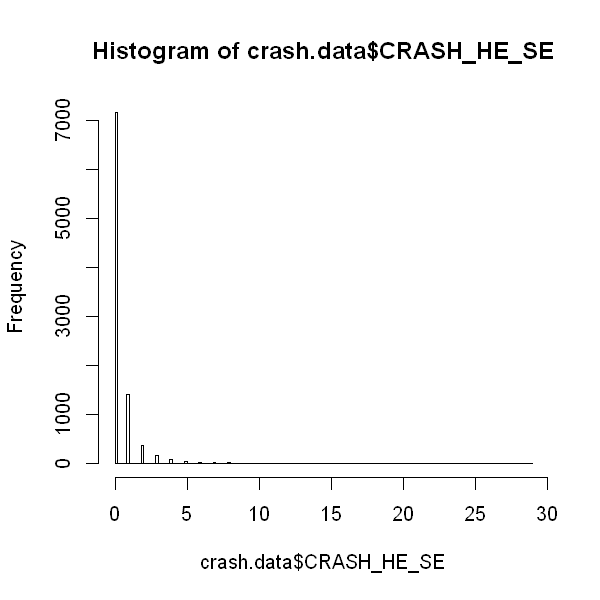

In [3]:
hist(crash.data$CRASH_HE_SE, breaks="scott")